<a href="https://colab.research.google.com/github/prazlook/Archives-Minitel/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Step 0

Install dependencies. Restart once if it says you need to

In [2]:
# only necessary for google colab! to load models into session
!git clone https://github.com/jyjblrd/Radial_Non_Planar_Slicer
!mv Radial_Non_Planar_Slicer/input_models ./input_models
!mkdir output_models

fatal: destination path 'Radial_Non_Planar_Slicer' already exists and is not an empty directory.
mv: cannot stat 'Radial_Non_Planar_Slicer/input_models': No such file or directory
mkdir: cannot create directory ‘output_models’: File exists


In [3]:
!pip install pyvista
!pip install networkx
!pip install pygcode
!pip install scipy

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
import numpy as np
import pyvista as pv
import networkx as nx
from pygcode import Line
import time
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

#### Step 1
Enter a model name from the input_models folder

This code deforms the mesh and outputs a file called output_models/MODEL_NAME_unwrapped.stl

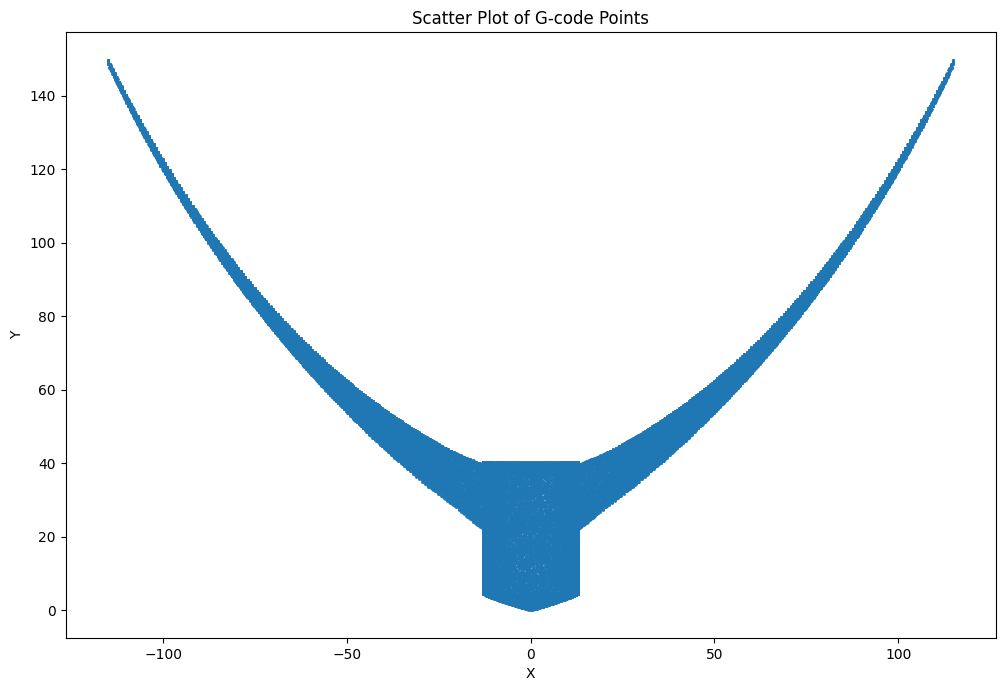

In [ ]:
MODEL_NAME = 'propeller'

# Load the mesh
mesh = pv.read(f'input_models/{MODEL_NAME}.stl')
mesh.field_data["faces"] = mesh.faces.reshape(-1, 4)[:, 1:] # assume all triangles

# scale mesh
mesh.points *= 1

# center around the middle of the bounding box
xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds
mesh.points -= np.array([(xmin + xmax) / 2, (ymin + ymax) / 2, zmin])
# mesh.points -= np.array([0, 0, 0]) # optionally offset the part from the center

mesh.points = mesh.points[:10]

# max radius of part
max_radius = np.max(np.linalg.norm(mesh.points[:, :2], axis=1))

# define rotation as a function of radius
ROTATION = lambda radius: np.deg2rad(15 + 30 * (radius / max_radius)) # Use for propeller and tree
# ROTATION = lambda radius: np.full_like(radius, np.deg2rad(-40)) # Fixed rotation inwards
# ROTATION = lambda radius: np.deg2rad(-40 + 30 * (1 - (radius / max_radius)) ** 2) # Use for bridge

# rotate points around max diameter ring
distances_to_center = np.linalg.norm(mesh.points[:, :2], axis=1)
translate_upwards = np.hstack([np.zeros((len(mesh.points), 2)), np.tan(ROTATION(distances_to_center).reshape(-1, 1)) * distances_to_center.reshape(-1, 1)])

mesh.points = mesh.points + translate_upwards

# make bottom of part z=0 and center in bound box. remember the offsets for later
xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds
offsets_applied = np.array([(xmin + xmax) / 2, (ymin + ymax) / 2, zmin])
mesh.points -= offsets_applied

# save the mesh
mesh.save(f'output_models/{MODEL_NAME}_unwrapped.stl')

# mesh.plot() # doesnt work in google colab?
# plot in matplot lib if in google colab
plt.figure(figsize=(12, 12))
plt.scatter(mesh.points[:, 0], mesh.points[:, 2], s=1)
plt.gca().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of G-code Points")
plt.show()

#### Step 2

Take output_models/MODEL_NAME_unwrapped.stl and slice it in cura. Make sure the origin of the printer is the center of the print bed, and that the model is in the middle of the printbed.

Upload MODEL_NAME_unwrapped.stl into input_models.

#### Step 3

Run the code below.

It parses the gcode and un-deforms it.

In [ ]:
# read gcode
pos = np.array([0., 0., 20.])
feed = 0
gcode_points = []
i = 0
with open(f'input_models/{MODEL_NAME}_unwrapped.gcode', 'r') as fh:
    for line_text in fh.readlines():
        line = Line(line_text)

        extrusion = None

        move_command_seen = False

        if not line.block.gcodes:
            continue

        # extract position and feedrate
        for gcode in sorted(line.block.gcodes):
            if gcode.word == "G01" or gcode.word == "G00":
                move_command_seen = True
                prev_pos = pos.copy()

                if gcode.X is not None:
                    pos[0] = gcode.X
                if gcode.Y is not None:
                    pos[1] = gcode.Y
                if gcode.Z is not None:
                    pos[2] = gcode.Z

            if gcode.word.letter == "F":
                feed = gcode.word.value

        if not move_command_seen:
            continue

        # extract extrusion
        for param in line.block.modal_params:
            if param.letter == "E":
                extrusion = param.value


        # segment moves
        # prevents G0 (rapid moves) from hitting the part
        # makes G1 (feed moves) less jittery
        delta_pos = pos - prev_pos
        distance = np.linalg.norm(delta_pos)
        if distance > 0 and gcode.word == "G01":
            seg_size = 1 # mm
            num_segments = -(-distance // seg_size) # hacky round up
            seg_distance = distance/num_segments

            # calculate inverse time feed
            time_to_complete_move = (1/feed) * seg_distance # min/mm * mm = min
            if time_to_complete_move == 0:
                inv_time_feed = None
            else:
                inv_time_feed = 1/time_to_complete_move # 1/min

            for i in range(int(num_segments)):
                gcode_points.append({
                    "position": (prev_pos + delta_pos * (i+1) / num_segments) + offsets_applied,
                    "command": gcode.word,
                    "extrusion": extrusion/num_segments if extrusion is not None else None,
                    "inv_time_feed": inv_time_feed,
                    "move_length": seg_distance,
                    "start_position": prev_pos,
                    "end_position": pos,
                    "unsegmented_move_length": distance
                })
        else:
            gcode_points.append({
                "position": pos.copy() + offsets_applied,
                "command": gcode.word,
                "extrusion": extrusion,
                "inv_time_feed": None,
                "move_length": 0
            })

# untransform gcode
positions = np.array([point["position"] for point in gcode_points])
distances_to_center = np.linalg.norm(positions[:, :2], axis=1)
translate_upwards = np.hstack([np.zeros((len(positions), 2)), np.tan(ROTATION(distances_to_center).reshape(-1, 1)) * distances_to_center.reshape(-1, 1)])

new_positions = positions - translate_upwards

# cap travel move height to be just above the part and to not travel over the origin
max_z = 0
for i, point in enumerate(gcode_points):
    if point["command"] == "G01":
        max_z = max(max_z, new_positions[i][2])
for i, point in enumerate(gcode_points):
    if point["command"] == "G00":
        if new_positions[i][2] > max_z:
            new_positions[i] = None


# rescale extrusion by change in move_length
prev_pos = np.array([0., 0., 0.])
for i, point in enumerate(gcode_points):
    if point["extrusion"] is not None and point["move_length"] != 0:
        extrusion_scale = np.linalg.norm(new_positions[i] - prev_pos) / point["move_length"]
        point["extrusion"] *= min(extrusion_scale, 10)
    prev_pos = new_positions[i]

# rescale extrusion to compensate for rotation deformation
distances_to_center = np.linalg.norm(new_positions[:, :2], axis=1)
extrusion_scales = np.cos(ROTATION(distances_to_center))
for i, point in enumerate(gcode_points):
    if point["extrusion"] is not None:
        point["extrusion"] *= extrusion_scales[i]



#### Step 4

Run the code below.

It writes the un-deformed model to output_models/MODEL_NAME_unwrapped.gcode

In [ ]:
NOZZLE_OFFSET = 43 # mm

prev_r = 0
prev_theta = 0
prev_z = 20

theta_accum = 0

# save transformed gcode
with open(f'output_models/{MODEL_NAME}_unwrapped.gcode', 'w') as fh:
    # write header
    fh.write("G94 ; mm/min feed  \n")
    fh.write("G28 ; home \n")
    fh.write("M83 ; relative extrusion \n")
    fh.write("G1 E10 ; prime extruder \n")
    fh.write("G94 ; mm/min feed \n")
    fh.write("G90 ; absolute positioning \n")
    fh.write(f"G0 C{prev_theta} X{prev_r} Z{prev_z} B{-np.rad2deg(ROTATION(0))}\n")
    fh.write("G93 ; inverse time feed \n")

    for i, point in enumerate(gcode_points):
        position = new_positions[i]

        if position is None:
            continue

        if np.all(np.isnan(position)):
            continue

        if position[2] < 0:
            continue

        #################################################################################################
        ### If you want to print on another type of 4 axis printer, you will need to change this code ###
        #################################################################################################
        # convert to polar coordinates
        r = np.linalg.norm(position[:2])
        theta = np.arctan2(position[1], position[0])
        z = position[2]

        rotation = ROTATION(r) * 1

        # compensate for nozzle offset
        r += np.sin(rotation) * NOZZLE_OFFSET
        z += (np.cos(rotation) - 1) * NOZZLE_OFFSET

        delta_theta = theta - prev_theta
        if delta_theta > np.pi:
            delta_theta -= 2*np.pi
        if delta_theta < -np.pi:
            delta_theta += 2*np.pi

        theta_accum += delta_theta

        string = f"{point['command']} C{np.rad2deg(theta_accum):.5f} X{r:.5f} Z{z:.5f} B{-np.rad2deg(rotation):.5f}"
        #################################################################################################
        ### If you want to print on another type of 4 axis printer, you will need to change this code ###
        #################################################################################################


        if point["extrusion"] is not None:
            string += f" E{point['extrusion']:.4f}"

        no_feed_value = False
        if point["inv_time_feed"] is not None:
            string += f" F{(point['inv_time_feed']):.4f}"
        else:
            string += f" F50000"
            fh.write(f"G94\n")
            no_feed_value = True

        fh.write(string + "\n")

        if no_feed_value:
            fh.write(f"G93\n") # back to inv feed

        # update previous values
        prev_r = r
        prev_theta = theta
        prev_z = z

#### Step 5

View the un-deformed model

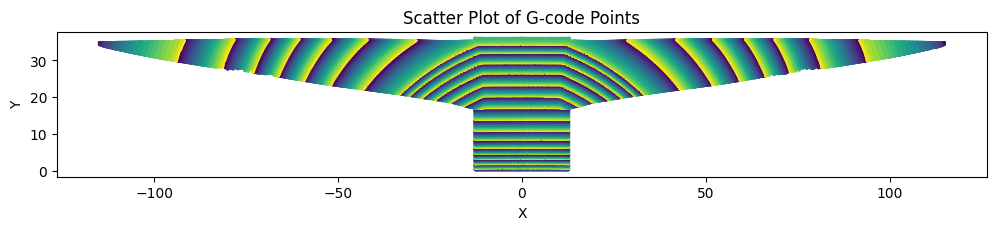

In [ ]:
# get where z > 0
z = new_positions[:, 2]
point_cloud = pv.PolyData(new_positions[z > 0])


# point_cloud.plot(scalars=np.arange(len(new_positions[z > 0]))%2000, point_size=20, render_points_as_spheres=True) # doesnt work in google colab? uncomment to view if not in google colab

# plot in matplotlib
g01_points = np.array([new_positions[i] for i, point in enumerate(gcode_points) if point["command"] == "G01"])
original_points = np.array([point["position"] for point in gcode_points if point["command"] == "G01"])

plt.figure(figsize=(12, 12))
c = original_points[:, 2][::-1] % 5 / 5
plt.scatter(g01_points[:, 0], g01_points[:, 2], s=1, c=c)
plt.gca().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of G-code Points")
plt.show()

#### Step 6

print MODEL_NAME_unwrapped.gcode